In [1]:
import numpy as np
from numpy.linalg import norm,inv,pinv,slogdet,matrix_rank
from numpy import array,trace,diag,zeros,ones,full,sqrt,eye
from scipy.stats import multivariate_normal
import pickle
import copy

from time import time
from tqdm import tnrange,tqdm_notebook

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle,Circle,Ellipse
import imageio


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman",
    "font.monospace": 'Computer Modern Typewriter'
})


import sys
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Plots

In [14]:
color_active_ranging = 'orange'
color_inactive_ranging = 'tomato'
color_active_doppler = 'green'
color_inactive_doppler = 'tomato'
color_target = 'blue'
color_est = 'red'

def plot_trajectories(ax,targets,sensors,ests,xlim,ylim,n_ranging_sensors,T_start=0):
    ax.scatter(targets[:,0,:], targets[:,1,:],c=color_target,alpha=0.02)
    ax.scatter(targets[-1,0,:], targets[-1,1,:],c=color_target,alpha=1,label='Target')
    
    if n_ranging_sensors>0:
        if T_start>0:
            ax.scatter(sensors[:T_start,0,:n_ranging_sensors], sensors[:T_start,1,:n_ranging_sensors],facecolors='none', edgecolors=color_inactive_ranging)
        ax.scatter(sensors[T_start:,0,:n_ranging_sensors], sensors[T_start:,1,:n_ranging_sensors], alpha=0.02,c=color_active_ranging)
        ax.scatter(sensors[-1,0,:n_ranging_sensors], sensors[-1,1,:n_ranging_sensors], alpha=1,c=color_active_ranging,label='Ranging sensor')
    
    if n_ranging_sensors==0 or n_ranging_sensors<sensors.shape[-1]:
        if T_start>0:
            ax.scatter(sensors[:T_start,0,n_ranging_sensors:], sensors[:T_start,1,n_ranging_sensors:],facecolors='none', edgecolors=color_inactive_doppler)

        ax.scatter(sensors[T_start:,0,n_ranging_sensors:], sensors[T_start:,1,n_ranging_sensors:], alpha=0.02,c=color_active_doppler)
        ax.scatter(sensors[-1,0,n_ranging_sensors:], sensors[-1,1,n_ranging_sensors:], alpha=1,c=color_active_doppler,label='Doppler sensor')
    
    ax.scatter(ests[:,0,:], ests[:,1,:], alpha=1,c='red',s=0.1,label='Estimate')
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel('$p_x$ [m]')
    ax.set_ylabel('$p_y$ [m]')

def plot_trajectories_xz(ax,title,targets,sensors,ests,xlim,ylim,n_ranging_sensors,T_start=0):
    ax.scatter(targets[:,0,:], targets[:,2,:],c=color_target,alpha=0.02)
    ax.scatter(targets[-1,0,:], targets[-1,2,:],c=color_target,alpha=1,label='Target')
    
    if n_ranging_sensors>0:
        if T_start>0:
            ax.scatter(sensors[:T_start,0,:n_ranging_sensors], sensors[:T_start,2,:n_ranging_sensors],facecolors='none', edgecolors=color_inactive_ranging)
        ax.scatter(sensors[T_start:,0,:n_ranging_sensors], sensors[T_start:,2,:n_ranging_sensors], alpha=0.02,c=color_active_ranging)
        ax.scatter(sensors[-1,0,:n_ranging_sensors], sensors[-1,2,:n_ranging_sensors], alpha=1,c=color_active_ranging,label='Ranging sensor')
    
    if n_ranging_sensors==0 or n_ranging_sensors<sensors.shape[-1]:
        if T_start>0:
            ax.scatter(sensors[:T_start,0,n_ranging_sensors:], sensors[:T_start,2,n_ranging_sensors:],facecolors='none', edgecolors=color_inactive_doppler)
            
        ax.scatter(sensors[T_start:,0,n_ranging_sensors:], sensors[T_start:,2,n_ranging_sensors:], alpha=0.02,c=color_active_doppler)
        ax.scatter(sensors[-1,0,n_ranging_sensors:], sensors[-1,2,n_ranging_sensors:], alpha=1,c=color_active_doppler,label='Doppler sensor')
    
    ax.scatter(ests[:,0,:], ests[:,2,:], alpha=1,c='red',s=0.1,label='Estimate')
    #ax.set_title(title)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel('$p_x$ [m]')
    ax.set_ylabel('$p_z$ [m]')
    
def plotframe(T,frame,rect,n_range_sensors,T_start=0):
    fig = plt.figure(figsize=(5,4))
    
    ax = plt.gca()

    dim,n_target = frame['est'].shape
    for nt in range(n_target):
        ax.add_patch(Circle((frame['target'][0,nt],frame['target'][1,nt]), 1, color=color_target,label='Target'))
    
    sensors = frame['sensor']
    obs = frame['obs']
    
    ranging_label=False
    for i in range(n_range_sensors):
        c = (sensors[0,i], sensors[1,i])
        r = obs[0,i]
        if frame["t"]>=T_start:
            if ranging_label==False:
                ax.add_patch(Circle(c, 1, color=color_active_ranging,label='Ranging sensor'))
                ranging_label=True
            else:
                ax.add_patch(Circle(c, 1, color=color_active_ranging))  
        else:
            ax.add_patch(Circle(c, 1, color=color_inactive_ranging))
    
    doppler_label = False
    for i in range(sensors.shape[1]-n_range_sensors):
        c = (sensors[0,i+n_range_sensors], sensors[1,i+n_range_sensors])
        if frame["t"]>=T_start:
            if doppler_label==False:
                ax.add_patch(Circle(c, 1, color=color_active_doppler,label='Doppler sensor'))
                doppler_label=True
            else:
                ax.add_patch(Circle(c, 1, color=color_active_doppler))
        else:
            ax.add_patch(Circle(c, 1, color=color_inactive_doppler))
    
    plt.title(f'T={frame["t"]}/{T} [s]')
    plt.ylim(rect[2],rect[3])
    plt.xlim(rect[0],rect[1])
    plt.legend(loc='upper left')
    
    plt.savefig(f'./img/img_{frame["t"]}.pdf', 
                    transparent = False,  
                    facecolor = 'white'
                   )
    
    plt.savefig(f'./img/img_{frame["t"]}.png', 
                    transparent = False,  
                    facecolor = 'white'
                   )
    fig.clf()
    plt.close(fig)
    
def plotgif(T,frames,rect,prefix,n_range_sensors):
    gif_imgs = []
    for frame in frames:
        plotframe(T,frame,rect,n_range_sensors)
        gif_imgs.append(imageio.v2.imread(f'./img/img_{frame["t"]}.png'))
    
    imageio.mimsave(f'./{prefix}_T={T}.gif',gif_imgs,fps = 10)  
    


In [2]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def save2file(line, cell):
    'save python code block to a file'
    with open(line, 'wt') as fd:
        fd.write(cell)

In [3]:
%%save2file tmp.py
import time

import numpy as np
from numpy.linalg import norm,inv,pinv,slogdet,matrix_rank
from numpy import array,trace,diag,zeros,ones,full,sqrt,eye
from scipy.stats import multivariate_normal
import pickle
import copy



import torch
from robusttracking.sensors import *
from robusttracking.estimator import *
from robusttracking.controller import move,move_scipy#,robustmove




import sys
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

torch.set_default_dtype(torch.double)

import sys
import os
import torch.multiprocessing as multiprocessing

import jax.numpy as jnp


def case_2D_4(T):
    x_t = zeros((4,1))
    x_t[0,0] = -5
    x_t[1,0] = 0
    x_t[3,0] = 23
    
    
    
    
    x_s = zeros((4,3))
    
    x_s[0,0] = -100
    x_s[0,1] = 100
    x_s[0,2] = 0
    x_s[1,0] = -200
    x_s[1,1] = -200
    x_s[1,2] = -100
    x_s[2,0] = 20
    x_s[2,1] = 10
    x_s[2,2] = 20
    
    u_t = zeros((4,1,T))
    u_t[2,0,:T//2] = -80/T
    u_t[2,0,T//2:] = 100/T
    u_t[3,0,T//3:2*T//3] = -200/T
    
    return x_t,x_s,u_t

def case_2D_5(T):
    x_t = zeros((4,1))
    x_t[0,0] = 1500
    x_t[2,0] = -5
    x_t[3,0] = 0
    
    
    
    x_s = zeros((4,3))
    x_s[0,0] = -100
    x_s[0,1] = 100
    x_s[0,2] = 0
    x_s[1,0] = -200
    x_s[1,1] = -200
    x_s[1,2] = -100
    x_s[2,0] = 20
    x_s[2,1] = 10
    x_s[2,2] = 20
    
    u_t = zeros((4,1,T))
    u_t[2,0,:T//2] = -25/T
    u_t[2,0,T//2:] = 10/T
    u_t[3,0,2*T//3:] = 10/T
    
    return x_t,x_s,u_t

def case_2D_7(T):
    x_t = zeros((4,2))
    x_t[0,0] = -5
    x_t[1,0] = 0
    x_t[3,0] = 23
    
    x_t[0,1] = 1500
    x_t[2,1] = -5
    x_t[3,1] = 0
    
    
    
    x_s = zeros((4,3))
    
    x_s[0,0] = -100
    x_s[0,1] = 100
    x_s[0,2] = 0
    x_s[1,0] = -200
    x_s[1,1] = -200
    x_s[1,2] = -100
    x_s[2,0] = 20
    x_s[2,1] = 10
    x_s[2,2] = 20
    
    u_t = zeros((4,2,T))
    u_t[2,0,:T//2] = -80/T
    u_t[2,0,T//2:] = 100/T
    u_t[3,0,T//3:2*T//3] = -200/T
    
    
    u_t[2,1,:T//2] = -25/T
    u_t[2,1,T//2:] = 10/T
    u_t[3,1,2*T//3:] = 10/T
    
    return x_t,x_s,u_t

def case_2D_9(T):
    x_t = zeros((4,1))
    x_t[0,0] = 900
    x_t[1,0] = -300
    x_t[2,0] = 10
    x_t[3,0] = 0
    
    x_s = zeros((4,3))
    
    x_s[0,0] = -200
    x_s[0,1] = 0
    x_s[0,2] = 200
    x_s[1,0] = -320
    x_s[1,1] = -350
    x_s[1,2] = -320
    
    u_t = zeros((4,1,T))
    
    
    u_t[2,0,:T//2] = 20/T
    u_t[2,0,T//2:] = -20/T
    u_t[3,0,T//4:T//2] = 30/T
    u_t[3,0,T//2:] = -30/T
    
    return x_t,x_s,u_t

def case_2D_13(T):
    x_t = zeros((4,1))
    x_t[0,0] = 2000
    x_t[1,0] = -300
    x_t[2,0] = 0
    x_t[3,0] = np.pi/T*2000
    
    x_s = zeros((4,3))
    
    x_s[0,0] = -200
    x_s[0,1] = 0
    x_s[0,2] = 200
    x_s[1,0] = -200
    x_s[1,1] = -400
    x_s[1,2] = 0
    
    u_t = zeros((4,1,T))
    
    omega = np.pi/T
    radius = 2000
    tangential_v = omega*radius
    theta = 0
    vx_ = - tangential_v * np.sin(theta)
    vy_ = tangential_v*np.cos(theta)
    for i in range(T):
        theta = omega*i
        vx = - tangential_v * np.sin(theta)
        vy = tangential_v*np.cos(theta)
        u_t[2,0,i] = vx-vx_
        u_t[3,0,i] = vy-vy_
        
        vx_ = vx
        vy_ = vy
    
    return x_t,x_s,u_t

def case_3D_18(T):
    x_t = zeros((6,2))
    x_t[0,0] = -5
    x_t[1,0] = 0
    x_t[4,0] = 23
    x_t[5,0] = -1
    
    x_t[0,1] = 1500
    x_t[3,1] = -5
    x_t[4,1] = 0
    x_t[5,1] = -1
    
    
    
    x_s = zeros((6,4))
    
    x_s[0,0] = -200
    x_s[0,1] = 0
    x_s[0,2] = 0
    x_s[0,3] = 200
    x_s[1,0] = -100
    x_s[1,1] = -300
    x_s[1,2] = 100
    x_s[1,3] = -100
    x_s[2,0] = 200
    x_s[2,1] = -100
    x_s[2,2] = 2
    x_s[2,3] = -2
    
    u_t = zeros((6,2,T))
    u_t[3,0,:T//2] = -80/T
    u_t[3,0,T//2:] = 100/T
    u_t[4,0,T//3:2*T//3] = -200/T
    
    
    u_t[3,1,:T//2] = -20/T
    u_t[3,1,T//2:] = 20/T
    u_t[4,1,:] = 50/T
    u_t[5,:,:T//2] = -10/T
    u_t[5,:,T//2:] = 10/T
    
    return x_t,x_s,u_t
def case_3D_19(T):
    x_t = zeros((6,2))
    x_t[0,0] = -5
    x_t[1,0] = 0
    x_t[4,0] = 23
    x_t[5,0] = -1
    
    x_t[0,1] = 1500
    x_t[3,1] = -5
    x_t[4,1] = 0
    x_t[5,1] = -1
    
    
    
    x_s = zeros((6,4))
    
    x_s[0,0] = -150
    x_s[0,1] = 0
    x_s[0,2] = 0
    x_s[0,3] = 150
    x_s[1,0] = -150
    x_s[1,1] = -300
    x_s[1,2] = 0
    x_s[1,3] = -150
    x_s[2,0] = 20
    x_s[2,1] = -50
    x_s[2,2] = 2
    x_s[2,3] = -2
    
    u_t = zeros((6,2,T))
    u_t[3,0,:T//2] = -80/T
    u_t[3,0,T//2:] = 100/T
    u_t[4,0,T//3:2*T//3] = -200/T
    
    
    u_t[3,1,:T//2] = -20/T
    u_t[3,1,T//2:] = 20/T
    u_t[4,1,:] = -50/T
    u_t[5,:,:T//2] = -10/T
    u_t[5,:,T//2:] = 10/T
    
    return x_t,x_s,u_t
def case_3D_20(T):
    x_t = zeros((6,2))
    x_t[0,0] = -5
    x_t[1,0] = 0
    x_t[4,0] = 23
    x_t[5,0] = -1
    
    x_t[0,1] = 1500
    x_t[3,1] = -5
    x_t[4,1] = 0
    x_t[5,1] = -1
    
    
    
    x_s = zeros((6,4))
    
    x_s[0,0] = -200
    x_s[0,1] = 0
    x_s[0,2] = 0
    x_s[0,3] = 200
    x_s[1,0] = -100
    x_s[1,1] = -300
    x_s[1,2] = 100
    x_s[1,3] = -100
    x_s[2,0] = 200
    x_s[2,1] = -100
    x_s[2,2] = 2
    x_s[2,3] = -2
    
    u_t = zeros((6,2,T))
    u_t[3,0,:T//2] = -80/T
    u_t[3,0,T//2:] = 100/T
    u_t[4,0,T//3:2*T//3] = -200/T
    
    
    u_t[3,1,:T//2] = -20/T
    u_t[3,1,T//2:] = 20/T
    u_t[5,:,:T//2] = -10/T
    u_t[5,:,T//2:] = 10/T
    
    return x_t,x_s,u_t

def case_3D_21(T):
    x_t = zeros((6,2))
    x_t[0,0] = -50
    x_t[1,0] = 0
    x_t[4,0] = 8
    
    x_t[0,1] = 0
    x_t[3,1] = 50
    x_t[3,1] = 8
    
    
    
    x_s = zeros((6,4))
    
    x_s[0,0] = -150
    x_s[0,1] = 150
    x_s[0,2] = 150
    x_s[0,3] = -150
    x_s[1,0] = 150
    x_s[1,1] = 150
    x_s[1,2] = -150
    x_s[1,3] = -150
    x_s[2,0] = 20
    x_s[2,1] = -10
    x_s[2,2] = 2
    x_s[2,3] = -2
    
    u_t = zeros((6,2,T))
    u_t[4,0,:T//3] =  60/T
    u_t[3,1,:T//3] =  60/T
    u_t[4,0,2*T//3:] = -60/T
    u_t[3,1,2*T//3:] = -60/T
    
    return x_t,x_s,u_t


def case_3D_22(T):
    x_t = zeros((6,1))
    x_t[0,0] = 605
    x_t[1,0] = 400
    x_t[4,0] = 23
    x_t[5,0] = -1
    
    
    
    x_s = zeros((6,6))
    
    x_s[0,0] = -200
    x_s[0,1] = 0
    x_s[0,2] = 0
    x_s[0,3] = 200
    x_s[0,4] = 0
    x_s[0,5] = 200
    
    x_s[1,0] = -100
    x_s[1,1] = -300
    x_s[1,2] = 100
    x_s[1,3] = -100
    x_s[1,4] = -300
    x_s[1,5] = 100
    
    x_s[2,0] = 200
    x_s[2,1] = -200
    x_s[2,2] = 0
    x_s[2,3] = -200
    x_s[2,4] = 200
    x_s[2,5] = 0
    
    u_t = zeros((6,1,T))
    u_t[3,0,:T//2] = -80/T
    u_t[3,0,T//2:] = 100/T
    u_t[4,0,T//3:2*T//3] = -200/T
    u_t[5,:,:T//2] = -10/T
    u_t[5,:,T//2:] = 10/T
    
    return x_t,x_s,u_t

def case_3D_23(T):
    x_t = zeros((6,1))
    x_t[0,0] = 500
    x_t[1,0] = 500
    x_t[3,0] = -10
    
    
    
    x_s = zeros((6,4))
    
    x_s[0,0] = -800
    x_s[0,1] = -800
    x_s[0,2] = 800
    x_s[0,3] = 0
    
    x_s[1,0] = 800
    x_s[1,1] = -800
    x_s[1,2] = 800
    x_s[1,3] = 0
    
    x_s[2,0] = 200
    x_s[2,1] = -200
    x_s[2,2] = 0
    x_s[2,3] = 0
        
    u_t = zeros((6,1,T))
    
    return x_t,x_s,u_t

def extract_frames(frames,evaluator):
    position_err = []
    sensor_trac = []
    target_trac = []
    est_trac = []
    velocity_err = []
    crb_p = []
    crb_v = []
    est_status = []
    v = []
    
    dim = frames[0]['target'].shape[0]//2
    n_target = frames[0]['target'].shape[-1]
    cov_prev = np.zeros((n_target,2*dim,2*dim))
    for it in range(n_target):
        cov_prev[it] = eye(2*dim)*1e12
    
    sensor_np,target_np = evaluator()
    
    for j in range(len(frames)):
        frame = frames[j]
        pe = ((frame['target'][:dim]-frame['est'][:dim])**2).sum(axis=0)
        position_err.append(pe)
        sensor_trac.append(frame['sensor'])
        target_trac.append(frame['target'])
        est_trac.append(frame['est'])
        
        
        
        x_t_n = frame['target']
        
        x_s_n = frame['sensor']
            
        fim = fisher_information(sensor_np.hx(x_t_n,x_s_n),sensor_np.sx(x_t_n,x_s_n),sensor_np.H(x_t_n,x_s_n),sensor_np.S(x_t_n,x_s_n))
        cov_prev_ = np.zeros((n_target,2*dim,2*dim))
        crbs_p = []
        crbs_v = []
        
        #a = np.zeros((2*dim,n_target))
        #a[dim:,:] =  1./12
        amax = 5
        
        for it in range(n_target):
            #Q = np.diag(a[:,it])
            
            Q = target_np.getUniformQ(amax)
            
            fi = inv(target_np.predictC(cov_prev[it],Q))
            fi[:fim[it].shape[0],:fim[it].shape[1]] += fim[it]
            C_ = inv(fi)
                
            crbs_p.append(diag(C_[:dim,:dim]).sum())
            crbs_v.append(diag(C_[dim:,dim:]).sum())
            cov_prev_[it] = C_.copy()
        crb_p.append(array(crbs_p))
        crb_v.append(array(crbs_v))
        cov_prev = cov_prev_.copy()
        
        est_status.append(frame['est_status'])
        
        ve = ((frame['target'][dim:]-frame['est'][dim:])**2).sum(axis=0)
        velocity_err.append(ve)
        
            
    ret = {'sensors':array(sensor_trac)
           ,'targets':array(target_trac)
           ,'ests':array(est_trac)
           ,'est_status':array(est_status)
          ,'mse_p':array(position_err)
          ,'crb_p':array(crb_p)
          ,'mse_v':array(velocity_err)
          ,'crb_v':array(crb_v)
           ,'frames':frames}
    
    return ret

def single_run(seed,T,K,sensor_torch,target_torch,sensor_jnp,sensor_np,target_np,lr_s,lr_t,rs,rt,rv,w,trajectory,est_0,dim,n_dynamic_sensors,Q,take_sigma = True, rho=0, S_min=None, S_max=None, nfc=None,S=None,r=None, multistarts=False,T_start=0,robust=True,gamma=1,n_iter=2000):
    """
    Params
        T: Total number of time step in tracking
        K: The time horizon for planning
        sensor_torch,sensor_np: Sensor simulator, the suffix distinguishes which framework it uses
        target_torch,target_np: Target simulator, the suffix distinguishes which framework it uses
        lr_s: Learning rate of maximization
        lr_t: Learning rate of minimzation
        rs: Bound of sensors' action
        rt: Bound of targets' action
        rv: Bound of initial estimation(95% quantile of chi square)
        w: weights of cost length(w)=K, the weight of cost of each step
        trajectory: a function, produce initial placement of sensors,targets and a trajectory of targets
        est_0: initial guess of target for MLE optimizer
        dim: 2 or 3, 2D or 3D
        n_dynamic_sensors: number of dynamic sensors in total
        T_start: when does the algorithm turn on, default zero
        robust: whether use minimax or minimize only
        gamma: the weight of velocity crb in costs
    return
        a list of frames 
    """
    frames = []
    np.random.seed(seed)
    
    x_t_n,x_s_n,u_t = trajectory(T)
    
    n_target = x_t_n.shape[-1]
    
    x_pred = est_0.copy()
    cov_pred = np.zeros((n_target,2*dim,2*dim))
    cov_prev = np.zeros((n_target,2*dim,2*dim))
    for it in range(n_target):
        cov_pred[it] = eye(2*dim)*1e12
        cov_prev[it] = eye(2*dim)*1e12
        
    
    
    init_u_s = np.random.randn(K,*x_s_n.shape)*0.001
    init_u_s[:,:dim,:] = 0
    
    
    
    for t in range(T):
        frame = {}
        
        frame['target'] = x_t_n
        frame['sensor'] = x_s_n
        
        #STEP 1. read observaion
        obs = observe(sensor_np.hx(x_t_n,x_s_n),sensor_np.sx(x_t_n,x_s_n))
        frame['obs'] = obs
        
        #STEP 2. estimate target
        est,C_sqt,status,C_est =  mle_fuse(sensor_np,x_pred,cov_pred,x_s_n,obs,multistarts)
        
        
        #print('est crb',C_est, status,'est',est)
        frame['est'] = est
        frame['C_sqt'] = C_sqt
        frame['est_status'] = status
        for it in range(n_target):
             cov_pred[it] = target_np.predictC(C_est[it],Q)
                
        #STEP 3. evaluate using true 
        fim = fisher_information(sensor_np.hx(x_t_n,x_s_n),sensor_np.sx(x_t_n,x_s_n),sensor_np.H(x_t_n,x_s_n),sensor_np.S(x_t_n,x_s_n))
        cov_prev_ = np.zeros((n_target,2*dim,2*dim))
        crb_rmse_p = []
        crb_rmse_v = []
        
        for it in range(n_target):
            fi = inv(target_np.predictC(cov_prev[it],Q)) #eq. 15
            fi[:fim[it].shape[0],:fim[it].shape[1]] += fim[it]
            C_ = inv(fi)
            crb_rmse_p.append(np.sqrt(diag(C_[:dim,:dim]).sum()))
            crb_rmse_v.append(np.sqrt(diag(C_[dim:,dim:]).sum()))
            cov_prev_[it] = C_.copy()
        cov_prev = cov_prev_.copy()
        #print(cov_prev,cov_pred)
    
        #not using anymore
        frame['crb_rmse_p'] = crb_rmse_p
        frame['crb_rmse_v'] = crb_rmse_v
        
        #STEP 4. plan nextmove
        if t>=T_start:
            u_s = move_scipy(K,sensor_jnp,target_np,x_s_n,est,rs,n_dynamic_sensors,C_est,S_min,S_max,rho,nfc,S,r,take_sigmapoints=take_sigma, Q = Q, init_u_s = jnp.array(init_u_s))
            u_s_n = u_s[0]
            init_u_s[:-1] = u_s[1:]
        else:#Haven't started yet
            u_s_n = np.zeros((x_s_n.shape[0],n_dynamic_sensors))
        
        
        #STEP 5. update prediction
        x_pred = target_np.transition(est,zeros(est.shape))
        
        #STEP 6. sensor act
        x_s_n = sensor_np.transition(x_s_n,u_s_n)
        print(x_s_n)
        #STEP 7. target act
        u_t_n = u_t[:,:,t]
        x_t_n = target_np.transition(x_t_n,u_t_n)
        
        frame['t'] = t
        frames.append(frame)
        frame_prev = frame
        
    return frames

def task(seed,frame_generator,evaluator,output,result_dict): 
    if os.path.isfile(output):
        with open(output,'rb') as f:
            frames_done = pickle.load(f)
    else:
        frames_done = {}
        
    if str(seed) in frames_done:
        frames = frames_done[str(seed)]
    else:
        frames = frame_generator(seed)
    
        
    result_dict[str(seed)] = extract_frames(frames,evaluator)
    


def monte_carlo_parallel(frame_generator,evaluator,output,output_pk,repeat,PROCESSES = 4):
   
    sensors = []
    targets = []
    ests = []
    est_status = []
    rmse_p = []
    crb_rmse_p = []
    rmse_v = []
    crb_rmse_v = []
    v = []
    
    seeds = [seed+25 for seed in range(repeat)]
    
    multiprocessing.freeze_support()
    processes = []
    result_dict = {}
    
    for i in range(int(np.ceil(len(seeds)/PROCESSES))):
        manager = multiprocessing.Manager()
        return_dict = manager.dict()
        jobs = []
        
        for j in range(min(PROCESSES,len(seeds)-i*PROCESSES)):
            seed = seeds[i*PROCESSES+j]
            print('join task = ',seed)
            p = multiprocessing.Process(target=task, args=(seed,frame_generator,evaluator,output,return_dict))
            jobs.append(p)
            p.start()

        for proc in jobs:
            proc.join()
       
        if os.path.isfile(output):
            with open(output,'rb') as f:
                frames_done = pickle.load(f)
        else:
            frames_done = {}

        for j in range(min(PROCESSES,len(seeds)-i*PROCESSES)):
            seed = seeds[i*PROCESSES+j]
            ret = return_dict[str(seed)]
            frames_done[str(seed)] = ret['frames']
            sensors.append(ret['sensors'])
            targets.append(ret['targets'])
            ests.append(ret['ests'])
            est_status.append(ret['est_status'])
            rmse_p.append(ret['mse_p'])
            crb_rmse_p.append(ret['crb_p'])
            rmse_v.append(ret['mse_v'])
            crb_rmse_v.append(ret['crb_v'])


        with open(output_pk,'wb') as f:
            pickle.dump((np.array(sensors),np.array(targets),np.array(ests),np.array(est_status),np.array(est_status),np.array(rmse_p),np.array(crb_rmse_p),np.array(rmse_v),np.array(crb_rmse_v),np.array(v)),f)

        with open(output,'wb') as f:
            pickle.dump(frames_done,f)
            
        time.sleep(1)
        
    print('done executing')


def task1(seed):
    #setting constant
    target2D_torch = Target2DT()
    target2D_np = Target2D()

    target3D_torch = Target3DT()
    target3D_np = Target3D()

    K = 6
    T = 100 
    lr_t = 0.01
    lr_s = 0.03
    w = torch.tensor([0. for k in range(K)])
    w[-1] = 1.

    dim = 2
    bmax = 2#0.02
    amax = 5#1.52
    range_u_s = [-bmax/np.sqrt(dim),bmax/np.sqrt(dim)]
    range_u_t = [-amax,amax]
    q = np.sqrt(q_alpha_d(2*dim))
    range_v = [-q,q]
    Q = target2D_np.getUniformQ(amax)
    x_init_guess = np.array([[-100.,0.3, 0, 0]]).T #a poor guess for mle initialization



    trajectory = case_2D_4
    n_dynamic_sensors = 3
    sensor_torch = RangingSensor2DT()
    sensor_np = RangingSensor2D()
    sensor_jnp = RangingSensor2DJ()

    x_max = np.array([[800.],[800],[10],[10]])
    x_min = np.array([[-800.],[-800],[-10],[-10]])
   
    return single_run(seed,T,K,sensor_torch,target2D_torch,sensor_jnp,sensor_np,target2D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,x_init_guess,dim,n_dynamic_sensors,Q,S_max = x_max,S_min=x_min,take_sigma=True,n_iter=3000)


def task2(seed):
    #setting constant
    target2D_torch = Target2DT()
    target2D_np = Target2D()

    K = 6
    T = 100 
    lr_t = 0.01
    lr_s = 0.03
    w = torch.tensor([0. for k in range(K)])
    w[-1] = 1.

    dim = 2
    bmax = 2#0.02
    amax = 5#1.52
    range_u_s = [-bmax/np.sqrt(dim),bmax/np.sqrt(dim)]
    range_u_t = [-amax,amax]
    q = np.sqrt(q_alpha_d(2*dim))
    range_v = [-q,q]
    Q = target2D_np.getUniformQ(amax)
    x_init_guess = np.array([[-500.,0.3, 0, 0],[500,0.3,0,0]]).T #a poor guess for mle initialization



    trajectory = case_2D_7
    n_dynamic_sensors = 3
    sensor_torch = RangingSensor2DT()
    sensor_np = RangingSensor2D()
    sensor_jnp = RangingSensor2DJ()

    x_max = np.array([[800.],[800],[15],[15]])
    x_min = np.array([[-800.],[-800],[-15],[-15]])
    return single_run(seed,T,K,sensor_torch,target2D_torch,sensor_jnp,sensor_np,target2D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,x_init_guess,dim,n_dynamic_sensors,Q,S_min=x_min,S_max=x_max,take_sigma=True,n_iter=3000)

def task3(seed):
    #setting constant
    target2D_torch = Target2DT()
    target2D_np = Target2D()

    target3D_torch = Target3DT()
    target3D_np = Target3D()

    K = 5
    T = 100 
    lr_t = 0.01
    lr_s = 0.03
    w = torch.tensor([0. for k in range(K)])
    w[-1] = 1.

    dim = 2
    bmax = 2#0.02
    amax = 5#1.52
    range_u_s = [-bmax/np.sqrt(dim),bmax/np.sqrt(dim)]
    range_u_t = [-amax,amax]
    q = np.sqrt(q_alpha_d(2*dim))
    range_v = [-q,q]
    Q = target2D_np.getUniformQ(amax)
    x_init_guess = np.array([[10,0.3,0,0]]).T #a poor guess for mle initialization



    trajectory = case_2D_5
    n_dynamic_sensors = 3
    sensor_torch = RangingSensor2DT()
    sensor_np = RangingSensor2D()

    x_max = torch.tensor([[800.],[800],[15],[15]])
    x_min = torch.tensor([[-800.],[-800],[-15],[-15]])
    S = torch.diag(torch.tensor([1./1600,1./1600,1./30,1./30]))
    rho = 400000.
    lb = S@x_min
    ub = S@x_max
    return single_run(seed,T,K,sensor_torch,target2D_torch,sensor_jnp,sensor_np,target2D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,x_init_guess,dim,n_dynamic_sensors,Q,S_min=x_min,S_max=x_max,take_sigma=True,n_iter=3000)
def task4(seed):
    #setting constant
    target2D_torch = Target2DT()
    target2D_np = Target2D()

    target3D_torch = Target3DT()
    target3D_np = Target3D()

    K = 5
    T = 100 
    lr_t = 0.01
    lr_s = 0.03
    w = torch.tensor([0. for k in range(K)])
    w[-1] = 1.

    dim = 2
    bmax = 2#0.02
    amax = 5#1.52
    range_u_s = [-bmax/np.sqrt(dim),bmax/np.sqrt(dim)]
    range_u_t = [-amax,amax]
    q = np.sqrt(q_alpha_d(2*dim))
    range_v = [-q,q]
    Q = target2D_np.getUniformQ(amax)
    x_init_guess = np.array([[10,0.3,0,0]]).T #a poor guess for mle initialization



    trajectory = case_2D_9
    n_dynamic_sensors = 3
    sensor_torch = RangingSensor2DT()
    sensor_np = RangingSensor2D()

    x_max = torch.tensor([[800.],[800],[15],[15]])
    x_min = torch.tensor([[-800.],[-800],[-15],[-15]])
    S = torch.diag(torch.tensor([1./1600,1./1600,1./30,1./30]))
    rho = 4000000.
    lb = S@x_min
    ub = S@x_max
    return single_run(seed,T,K,sensor_torch,target2D_torch,sensor_np,target2D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,x_init_guess,dim,n_dynamic_sensors,Q,S_min=x_min,S_max=x_max,take_sigma=True,n_iter=3000)

def task5(seed):
    #setting constant
    target2D_torch = Target2DT()
    target2D_np = Target2D()

    target3D_torch = Target3DT()
    target3D_np = Target3D()

    K = 6
    T = 100 
    lr_t = 0.01
    lr_s = 0.08
    w = torch.tensor([0. for k in range(K)])
    w[-1] = 1.

    dim = 2
    bmax = 2#0.02
    amax = 5#1.52
    range_u_s = [-bmax/np.sqrt(dim),bmax/np.sqrt(dim)]
    range_u_t = [-amax,amax]
    q = np.sqrt(q_alpha_d(2*dim))
    range_v = [-q,q]
    Q = target2D_np.getUniformQ(amax)
    x_init_guess = np.array([[10,0.3,0,0]]).T #a poor guess for mle initialization



    trajectory = case_2D_13
    n_dynamic_sensors = 3
    sensor_torch = RangingSensor2DT()
    sensor_np = RangingSensor2D()
    sensor_jnp = RangingSensor2DJ()

    x_max = torch.tensor([[800.],[800],[15],[15]])
    x_min = torch.tensor([[-800.],[-800],[-15],[-15]])
    S = torch.diag(torch.tensor([1./1600,1./1600,1./30,1./30]))
    rho = 4000000.
    lb = x_min#S@x_min
    ub = x_max#S@x_max
    return single_run(seed,T,K,sensor_torch,target2D_torch,sensor_jnp,sensor_np,target2D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,x_init_guess,dim,n_dynamic_sensors,Q,S_min=x_min,S_max=x_max,take_sigma=False,n_iter=3000)
def task6(seed):
    #setting constant
    target2D_torch = Target2DT()
    target2D_np = Target2D()

    target3D_torch = Target3DT()
    target3D_np = Target3D()

    K = 6
    T = 100 
    lr_t = 0.01
    lr_s = 0.08
    w = torch.tensor([0. for k in range(K)])
    w[-1] = 1.

    dim = 2
    bmax = 2#0.02
    amax = 5#1.52
    range_u_s = [-bmax/np.sqrt(dim),bmax/np.sqrt(dim)]
    range_u_t = [-amax,amax]
    q = np.sqrt(q_alpha_d(2*dim))
    range_v = [-q,q]
    Q = target2D_np.getUniformQ(amax)
    x_init_guess = np.array([[10,0.3,0,0]]).T #a poor guess for mle initialization



    trajectory = case_2D_13
    n_dynamic_sensors = 3
    sensor_torch = RangingSensor2DT()
    sensor_np = RangingSensor2D()
    sensor_jnp = RangingSensor2DJ()

    x_max = torch.tensor([[800.],[800],[15],[15]])
    x_min = torch.tensor([[-800.],[-800],[-15],[-15]])
    S = torch.diag(torch.tensor([1./1600,1./1600,1./30,1./30]))
    rho = 4000000.
    lb = x_min
    ub = x_max
    return single_run(seed,T,K,sensor_torch,target2D_torch,sensor_jnp,sensor_np,target2D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,x_init_guess,dim,n_dynamic_sensors,Q,S_min=x_min,S_max=x_max,take_sigma=True,n_iter=3000)

def task15(seed):
    #setting constant
    target2D_torch = Target2DT()
    target2D_np = Target2D()

    K = 6
    T = 100 
    lr_t = 0.01
    lr_s = 0.08
    w = torch.tensor([0. for k in range(K)])
    w[-1] = 1.

    dim = 2
    bmax = 2#0.02
    amax = 500
    range_u_s = [-bmax/np.sqrt(dim),bmax/np.sqrt(dim)]
    range_u_t = [-amax,amax]
    q = np.sqrt(q_alpha_d(2*dim))
    range_v = [-q,q]
    Q = target2D_np.getUniformQ(amax)
    x_init_guess = np.array([[10,0.3,0,0]]).T #a poor guess for mle initialization



    trajectory = case_2D_13
    n_dynamic_sensors = 3
    sensor_torch = RangingSensor2DT()
    sensor_np = RangingSensor2D()
    sensor_jnp = RangingSensor2DJ()

    x_max = np.array([[800.],[800],[15],[15]])
    x_min = np.array([[-800.],[-800],[-15],[-15]])
    return single_run(seed,T,K,sensor_torch,target2D_torch,sensor_jnp,sensor_np,target2D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,x_init_guess,dim,n_dynamic_sensors,Q,S_min=x_min,S_max=x_max,take_sigma=True,n_iter=3000)

def task16(seed):
    #setting constant
    target2D_torch = Target2DT()
    target2D_np = Target2D()

    K = 2
    T = 100 
    lr_t = 0.01
    lr_s = 0.08
    w = torch.tensor([0. for k in range(K)])
    w[-1] = 1.

    dim = 2
    bmax = 2#0.02
    amax = 5
    range_u_s = [-bmax/np.sqrt(dim),bmax/np.sqrt(dim)]
    range_u_t = [-amax,amax]
    q = np.sqrt(q_alpha_d(2*dim))
    range_v = [-q,q]
    Q = target2D_np.getUniformQ(amax)
    x_init_guess = np.array([[10,0.3,0,0]]).T #a poor guess for mle initialization



    trajectory = case_2D_13
    n_dynamic_sensors = 3
    sensor_torch = RangingSensor2DT()
    sensor_np = RangingSensor2D()
    sensor_jnp = RangingSensor2DJ()

    x_max = np.array([[800.],[800],[15],[15]])
    x_min = np.array([[-800.],[-800],[-15],[-15]])
    return single_run(seed,T,K,sensor_torch,target2D_torch,sensor_jnp,sensor_np,target2D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,x_init_guess,dim,n_dynamic_sensors,Q,S_min=x_min,S_max=x_max,take_sigma=True,n_iter=3000)
def task17(seed):
    #setting constant
    target2D_torch = Target2DT()
    target2D_np = Target2D()

    K = 4
    T = 100 
    lr_t = 0.01
    lr_s = 0.08
    w = torch.tensor([0. for k in range(K)])
    w[-1] = 1.

    dim = 2
    bmax = 2#0.02
    amax = 5
    range_u_s = [-bmax/np.sqrt(dim),bmax/np.sqrt(dim)]
    range_u_t = [-amax,amax]
    q = np.sqrt(q_alpha_d(2*dim))
    range_v = [-q,q]
    Q = target2D_np.getUniformQ(amax)
    x_init_guess = np.array([[10,0.3,0,0]]).T #a poor guess for mle initialization



    trajectory = case_2D_13
    n_dynamic_sensors = 3
    sensor_torch = RangingSensor2DT()
    sensor_np = RangingSensor2D()
    sensor_jnp = RangingSensor2DJ()

    x_max = np.array([[800.],[800],[15],[15]])
    x_min = np.array([[-800.],[-800],[-15],[-15]])
    return single_run(seed,T,K,sensor_torch,target2D_torch,sensor_jnp,sensor_np,target2D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,x_init_guess,dim,n_dynamic_sensors,Q,S_min=x_min,S_max=x_max,take_sigma=True,n_iter=3000)


def task7(seed):
    target3D_torch = Target3DT()
    target3D_np = Target3D()
    
    K = 6
    T = 100 
    lr_t = 0.01
    lr_s = 0.1#0.08
    w = torch.tensor([0. for k in range(K)])
    w[-1] = 1.
    
    dim = 3
    bmax = 2
    amax = 5
    q = q_alpha_d(2*dim)

    range_u_s = [-bmax/np.sqrt(dim),bmax/np.sqrt(dim)]
    range_u_t = [-amax,amax]
    range_v = [-q,q]
    Q = target3D_np.getUniformQ(amax)


    x_init_guess = np.array([[-1000.,0.3,0,0, 0, 0],[1000.,0.3,0,0, 0, 0]]).T #a poor guess for mle initialization


    print(range_u_s)
    trajectory = case_3D_18
    n_dynamic_sensors = 4
    sensor_torch = MixedRangingDoppler3DFullT(3,0,0)
    sensor_jnp = MixedRangingDoppler3DFullJ(3,0,0)
    sensor_np = MixedRangingDoppler3DFull(3,0,0)
    
    x_max = torch.tensor([[800.],[800],[800],[15],[15],[15]])
    x_min = torch.tensor([[-800.],[-800],[-800],[-15],[-15],[-15]])
    return single_run(seed,T,K,sensor_torch,target3D_torch,sensor_jnp,sensor_np,target3D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,x_init_guess,dim,n_dynamic_sensors,Q,S_min=x_min,S_max=x_max,take_sigma=True,n_iter=3000)

def task8(seed):
    target3D_torch = Target3DT()
    target3D_np = Target3D()
    
    K = 7
    T = 100 
    lr_t = 0.01
    lr_s = 0.1#0.08
    w = torch.tensor([0. for k in range(K)])
    w[-1] = 1.
    
    dim = 3
    bmax = 2
    amax = 5
    q = q_alpha_d(2*dim)

    range_u_s = [-bmax/np.sqrt(dim),bmax/np.sqrt(dim)]
    range_u_t = [-amax,amax]
    range_v = [-q,q]
    Q = target3D_np.getUniformQ(amax)


    x_init_guess = np.array([[-1000.,0.3,0,0, 0, 0],[1000.,0.3,0,0, 0, 0]]).T #a poor guess for mle initialization


    trajectory = case_3D_21
    n_dynamic_sensors = 4
    sensor_torch = MixedRangingDoppler3DFullT(3,0,0)
    sensor_jnp = MixedRangingDoppler3DFullJ(3,0,0)
    sensor_np = MixedRangingDoppler3DFull(3,0,0)
    
    
    x_max = np.array([[800.],[800],[800],[15],[15],[15]])
    x_min = np.array([[-800.],[-800],[-800],[-15],[-15],[-15]])
    
    return single_run(seed,T,K,sensor_torch,target3D_torch,sensor_jnp,sensor_np,target3D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,x_init_guess,dim,n_dynamic_sensors,Q,S_min=x_min,S_max=x_max,take_sigma=True,n_iter=3000)


def task9(seed):
    target3D_torch = Target3DT()
    target3D_np = Target3D()
    
    K = 7
    T = 100 
    lr_t = 0.01
    lr_s = 0.1#0.08
    w = torch.tensor([0. for k in range(K)])
    w[-1] = 1.
    
    dim = 3
    bmax = 2
    amax = 5
    q = q_alpha_d(2*dim)

    range_u_s = [-bmax/np.sqrt(dim),bmax/np.sqrt(dim)]
    range_u_t = [-amax,amax]
    range_v = [-q,q]
    Q = target3D_np.getUniformQ(amax)


    x_init_guess = np.array([[-1000.,0.3,0,0, 0, 0],[1000.,0.3,0,0, 0, 0]]).T #a poor guess for mle initialization


    trajectory = case_3D_20
    n_dynamic_sensors = 4
    sensor_torch = MixedRangingDoppler3DFullT(3,0,0)
    sensor_jnp = MixedRangingDoppler3DFullJ(3,0,0)
    sensor_np = MixedRangingDoppler3DFull(3,0,0)
    
    x_max = np.array([[800.],[800],[800],[15],[15],[15]])
    x_min = np.array([[-800.],[-800],[-800],[-15],[-15],[-15]])

    return single_run(seed,T,K,sensor_torch,target3D_torch,sensor_jnp,sensor_np,target3D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,x_init_guess,dim,n_dynamic_sensors,Q,S_min=x_min,S_max=x_max,take_sigma=True,n_iter=3000)

def task10(seed):
    target3D_torch = Target3DT()
    target3D_np = Target3D()
    
    K = 7
    T = 100 
    lr_t = 0.01
    lr_s = 0.1#0.08
    w = torch.tensor([0. for k in range(K)])
    w[-1] = 1.
    
    dim = 3
    bmax = 2
    amax = 5
    q = q_alpha_d(2*dim)

    range_u_s = [-bmax/np.sqrt(dim),bmax/np.sqrt(dim)]
    range_u_t = [-amax,amax]
    range_v = [-q,q]
    Q = target3D_np.getUniformQ(amax)


    x_init_guess = np.array([[-1000.,0.3,0,0, 0, 0],[1000.,0.3,0,0, 0, 0]]).T #a poor guess for mle initialization


    trajectory = case_3D_21
    n_dynamic_sensors = 4
    sensor_torch = RangingSensor3DFullT()
    sensor_np = RangingSensor3DFull()
    sensor_jnp = RangingSensor3DFullJ()
    
    x_max = np.array([[800.],[800],[800],[15],[15],[15]])
    x_min = np.array([[-800.],[-800],[-800],[-15],[-15],[-15]])
    return single_run(seed,T,K,sensor_torch,target3D_torch,sensor_jnp,sensor_np,target3D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,x_init_guess,dim,n_dynamic_sensors,Q,S_min=x_min,S_max=x_max,take_sigma=True,n_iter=3000)


def task11(seed):
    target3D_torch = Target3DT()
    target3D_np = Target3D()
    
    K = 7
    T = 100 
    lr_t = 0.01
    lr_s = 0.1#0.08
    w = torch.tensor([0. for k in range(K)])
    w[-1] = 1.
    
    dim = 3
    bmax = 2
    amax = 5
    q = q_alpha_d(2*dim)

    range_u_s = [-bmax/np.sqrt(dim),bmax/np.sqrt(dim)]
    range_u_t = [-amax,amax]
    range_v = [-q,q]
    Q = target3D_np.getUniformQ(amax)


    x_init_guess = np.array([[1000.,0.3,0,0, 0, 0]]).T #a poor guess for mle initialization


    trajectory = case_3D_22
    n_dynamic_sensors = 6
    sensor_torch = DopplerSensorFullT()
    sensor_np = DopplerSensorFull()
    sensor_jnp = DopplerSensorFullJ()
    
    x_max = np.array([[800.],[800],[800],[15],[15],[15]])
    x_min = np.array([[-800.],[-800],[-800],[-15],[-15],[-15]])
    return single_run(seed,T,K,sensor_torch,target3D_torch,sensor_jnp,sensor_np,target3D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,x_init_guess,dim,n_dynamic_sensors,Q,S_min=x_min,S_max=x_max,take_sigma=True,n_iter=3000)


def task12(seed):
    target3D_torch = Target3DT()
    target3D_np = Target3D()
    
    K = 7
    T = 100 
    lr_t = 0.01
    lr_s = 0.1#0.08
    w = torch.tensor([0. for k in range(K)])
    w[-1] = 1.
    
    dim = 3
    bmax = 2
    amax = 5
    q = q_alpha_d(2*dim)

    range_u_s = [-bmax/np.sqrt(dim),bmax/np.sqrt(dim)]
    range_u_t = [-amax,amax]
    range_v = [-q,q]
    Q = target3D_np.getUniformQ(amax)


    x_init_guess = np.array([[1000.,0.3,0,0, 0, 0]]).T #a poor guess for mle initialization


    trajectory = case_3D_22
    n_dynamic_sensors = 6
    sensor_torch = DopplerSensorFullT()
    sensor_np = DopplerSensorFull()
    sensor_jnp = DopplerSensorFullJ()
    
    x_max = np.array([[800.],[800],[800],[15],[15],[15]])
    x_min = np.array([[-800.],[-800],[-800],[-15],[-15],[-15]])
    return single_run(seed,T,K,sensor_torch,target3D_torch,sensor_jnp,sensor_np,target3D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,x_init_guess,dim,n_dynamic_sensors,Q,S_min=x_min,S_max=x_max,take_sigma=True,n_iter=3000,T_start=50)

def task13(seed):
    target3D_torch = Target3DT()
    target3D_np = Target3D()
    
    K = 7
    T = 100 
    lr_t = 0.01
    lr_s = 0.1#0.08
    w = torch.tensor([0. for k in range(K)])
    w[-1] = 1.
    
    dim = 3
    bmax = 2
    amax = 5
    q = q_alpha_d(2*dim)

    range_u_s = [-bmax/np.sqrt(dim),bmax/np.sqrt(dim)]
    range_u_t = [-amax,amax]
    range_v = [-q,q]
    Q = target3D_np.getUniformQ(amax)


    x_init_guess = np.array([[1000.,0.3,0,0, 0, 0]]).T #a poor guess for mle initialization


    trajectory = case_3D_23
    n_dynamic_sensors = 4
    sensor_torch = MixedRangingDoppler3DFullT(3,0,0)
    sensor_np = MixedRangingDoppler3DFull(3,0,0)
    sensor_jnp = MixedRangingDoppler3DFullJ(3,0,0)
    
    x_max = np.array([[800.],[800],[800],[15],[15],[15]])
    x_min = np.array([[-800.],[-800],[-800],[-15],[-15],[-15]])
    return single_run(seed,T,K,sensor_torch,target3D_torch,sensor_jnp,sensor_np,target3D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,x_init_guess,dim,n_dynamic_sensors,Q,S_min=x_min,S_max=x_max,take_sigma=True,n_iter=3000,T_start=0)

def task14(seed):
    target3D_torch = Target3DT()
    target3D_np = Target3D()
    
    K = 7
    T = 100 
    lr_t = 0.01
    lr_s = 0.1#0.08
    w = torch.tensor([0. for k in range(K)])
    w[-1] = 1.
    
    dim = 3
    bmax = 2
    amax = 5
    q = q_alpha_d(2*dim)

    range_u_s = [-bmax/np.sqrt(dim),bmax/np.sqrt(dim)]
    range_u_t = [-amax,amax]
    range_v = [-q,q]
    Q = target3D_np.getUniformQ(amax)


    x_init_guess = np.array([[1000.,0.3,0,0, 0, 0]]).T #a poor guess for mle initialization


    trajectory = case_3D_23
    n_dynamic_sensors = 4
    sensor_torch = RangingSensor3DFullT()
    sensor_np = RangingSensor3DFull()
    sensor_jnp = RangingSensor3DFullJ()
    
    x_max = np.array([[800.],[800],[800],[15],[15],[15]])
    x_min = np.array([[-800.],[-800],[-800],[-15],[-15],[-15]])
    return single_run(seed,T,K,sensor_torch,target3D_torch,sensor_jnp,sensor_np,target3D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,x_init_guess,dim,n_dynamic_sensors,Q,S_min=x_min,S_max=x_max,take_sigma=True,n_iter=3000,T_start=0)



def evaluator1():
    return RangingSensor2D(),Target2D()

def evaluator2():
    return MixedRangingDoppler3DFull(3,0,0),Target3D()

def evaluator3():
    return DopplerSensorFull(),Target3D()

def evaluator4():
    return RangingSensor3DFull(),Target3D()


if __name__ == '__main__':
    torch.set_default_dtype(torch.double)
    __spec__ = "ModuleSpec(name='builtins', loader=<class '_frozen_importlib.BuiltinImporter'>)"
    
    
    monte_carlo_parallel(task1,evaluator1,'plotsdata/frames_1.pk','plotsdata/result_1.pk',101,PROCESSES = 7)
    #monte_carlo_parallel(task2,evaluator1,'plotsdata/frames_2.pk','plotsdata/result_2.pk',100,PROCESSES = 7)

In [ ]:
%run tmp.py

In [306]:
with open('plotsdata/result_1.pk','rb') as f:
    sensors1,targetes1,ests1,_,_,mse_p1,crb_p1,mse_v1,crb_v1,_ = pickle.load(f)

    
err_p1 = np.sqrt(mse_p1)
err_v1 = np.sqrt(mse_v1)
rmse_p1 = np.sqrt(mse_p1.mean(axis=0))
rmse_v1 = np.sqrt(mse_v1.mean(axis=0))
rcrb_p1 = np.sqrt(crb_p1.mean(axis=0))
rcrb_v1 = np.sqrt(crb_v1.mean(axis=0))

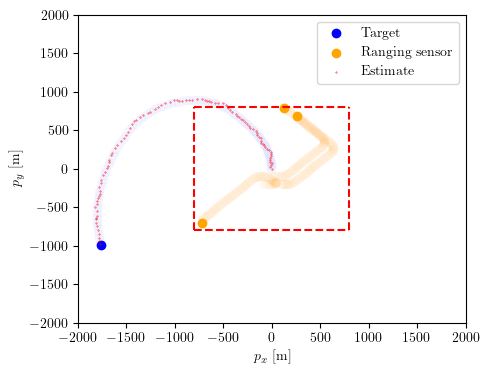

In [308]:
plt.figure(figsize=(5,4))
ax=plt.gca()
xlim = [-2000,2000]
ylim = [-2000,2000]
plot_trajectories(ax,targetes1[2], sensors1[2],ests1[2],xlim,ylim,3)
plt.plot([-800,-800],[-800,800],c='red',linestyle='dashed')
plt.plot([800,800],[-800,800],c='red',linestyle='dashed')
plt.plot([-800,800],[-800,-800],c='red',linestyle='dashed')
plt.plot([-800,800],[800,800],c='red',linestyle='dashed')
plt.legend()
plt.savefig('one-targe-ranging-trajectory.pdf')

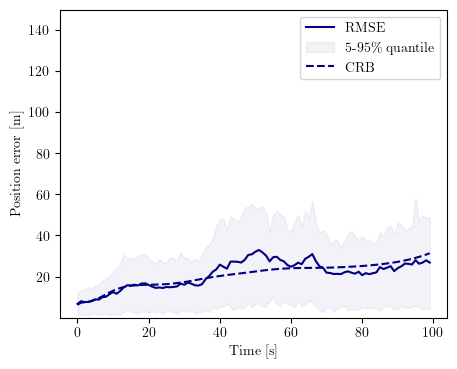

In [375]:
plt.figure(figsize=(5,4))

ax=plt.gca()
plt.plot(rmse_p1,c='navy',label='RMSE')
plt.fill_between(range(100),np.quantile(err_p1[:,:,0],0.05,axis=0),np.quantile(err_p1[:,:,0],0.95,axis=0),color='navy',alpha=0.05,label='5-95\% quantile')
plt.plot(rcrb_p1,c='navy',linestyle='dashed',label='CRB')
plt.xlabel('Time [s]')
plt.ylabel('Position error [m]')
#plt.ylim(1e-2,5)
#plt.yscale('log')
plt.ylim(1e-2,150)
plt.legend(loc='best')
plt.savefig('one-target-ranging-err-v2.pdf')

In [310]:
with open('plotsdata/result_2.pk','rb') as f:
    sensors2,targetes2,ests2,_,_,mse_p2,crb_p2,mse_v2,crb_v2,_ = pickle.load(f)
    
err_p2 = np.sqrt(mse_p2)
err_v2 = np.sqrt(mse_v2)
rmse_p2 = np.sqrt(mse_p2.mean(axis=0))
rmse_v2 = np.sqrt(mse_v2.mean(axis=0))
rcrb_p2 = np.sqrt(crb_p2.mean(axis=0))
rcrb_v2 = np.sqrt(crb_v2.mean(axis=0))

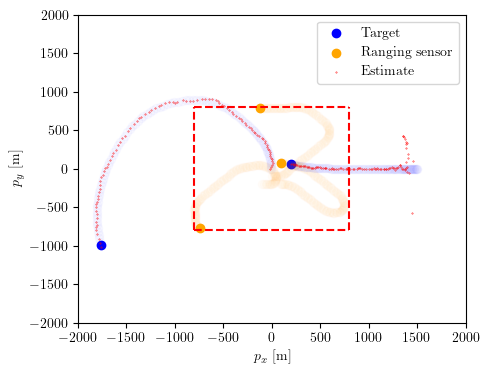

In [312]:
plt.figure(figsize=(5,4))
ax=plt.gca()
xlim = [-2000,2000]
ylim = [-2000,2000]
plot_trajectories(ax,targetes2[1], sensors2[1],ests2[1],xlim,ylim,3)
plt.plot([-800,-800],[-800,800],c='red',linestyle='dashed')
plt.plot([800,800],[-800,800],c='red',linestyle='dashed')
plt.plot([-800,800],[-800,-800],c='red',linestyle='dashed')
plt.plot([-800,800],[800,800],c='red',linestyle='dashed')
plt.legend()
plt.savefig('two-targets-ranging-trajectories.pdf')

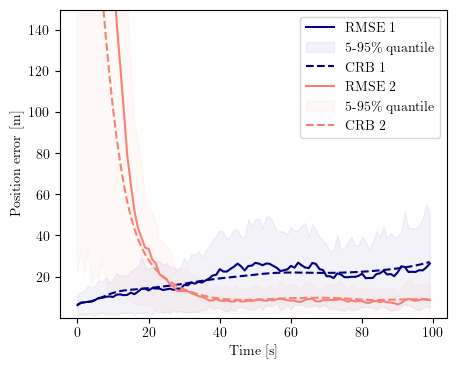

In [317]:
plt.figure(figsize=(5,4))

ax=plt.gca()
plt.plot(rmse_p2[:,0],c='navy',label='RMSE 1')
plt.fill_between(range(100),np.quantile(err_p2[:,:,0],0.05,axis=0),np.quantile(err_p2[:,:,0],0.95,axis=0),color='navy',alpha=0.05,label='5-95\% quantile')
plt.plot(rcrb_p2[:,0],c='navy',linestyle='dashed',label='CRB 1')


plt.plot(rmse_p2[:,1],c='salmon',label='RMSE 2')
plt.fill_between(range(100),np.quantile(err_p2[:,:,1],0.05,axis=0),np.quantile(err_p2[:,:,1],0.95,axis=0),color='salmon',alpha=0.05,label='5-95\% quantile')
plt.plot(rcrb_p2[:,1],c='salmon',linestyle='dashed',label='CRB 2')
plt.xlabel('Time [s]')
plt.ylabel('Position error [m]')
plt.ylim(1e-2,150)
#plt.yscale('log')
plt.legend(loc='best')
plt.savefig('two-targets-ranging-err-v3.pdf')